# Capstone Project - The Battle of the Neighborhoods - Los Angeles


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [Future Direction](#Future Direction)
* [Reference](#reference)



## Introduction: Business Problem <a name="introduction"></a>

This is a capstone project for **IBM Data Science Professional Certificate**. In this project we will try to find best neighborhood candidates for a restaurant in the city of Los Angeles, United States. Specifically, this report will be targeted to stakeholders interested in opening an restaurant in Los Angeles.

Since there are lots of neighborhoods in Los Angeles we will try to detect **neighborhood candidates that are not already crowded with restaurants and have favorable charateristics to support new restaurants**. We are also particularly interested in **neighborhoods with larger population base and higher household income**. We would also prefer locations **with lower business cost and crime rate**.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Density of existing restaurants and environment of the neighborhood
* Population base and household income in the neighborhood
* Business cost and crime rate in the neighborhood

Following data sources will be needed to extract/generate the required information:
* Most common venues and characteristics of every neighborhood will be obtained using **Foursquare API**
* Coordinate of each neighborhood will be obtained using **'LA_Neighborhoods.csv'** downloaded from Neighborhood Data for Social Change (NDSC) platform
* Populaiton base, median householder income, rent cost and crime rate of each neighborhood will be obtained using **'Total_Population__LA_.csv', 'Median_Household_Income__LA_.csv', 'Rent_Price__LA_.csv', and 'Part_I_Crimes__LA_.csv'** also downloaded from Neighborhood Data for Social Change (NDSC) platform

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting neighborhoods of Los Angeles that have low restaurant density, particularly those with larger population base, higher household income, lower rent cost and lower crime rate.

In first step we have collected the required data.

Second step in our analysis will be exploration of various datasets and clean and merge them into one master data with interested attributes and derive a few additional attributes such as population density, restaurant density and crime rate as an input for our training model.

In third and final step we will use unsupervised learning **K-means Clustering** to identify the most promising cluster and then our attention on the best neighborhood in the cluster, which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

#### Data Pre-processing

Let's import necessary libraries and load the datasets:

In [892]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn import preprocessing

In [872]:
df_coordinate=pd.read_csv('LA_Neighborhoods.csv')
df_population=pd.read_csv('Total_Population__LA_.csv')
df_income=pd.read_csv('Median_Household_Income__LA_.csv')
df_rent=pd.read_csv('Rent_Price__LA_.csv')
df_crime=pd.read_csv('Part_I_Crimes__LA_.csv')

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. 

First let's check on the **neighborhoods coordinates**:

In [484]:
df_coordinate.head()

,the_geom,set,slug,kind,external_i,name,display_na,sqmi,type,name_1,slug_1,Neighborho,Region,Descriptio,Source_Lin
0,MULTIPOLYGON (((-118.20261747920541 34.5389897...,L.A. County Neighborhoods (Current),acton,L.A. County Neighborhood (Current),acton,Acton,Acton L.A. County Neighborhood (Current),39.339109,unincorporated-area,NaN,NaN,Acton,Antelope Valley,Acton is an unincorporated area in the Antelop...,http://maps.latimes.com/neighborhoods/neighbor...
1,MULTIPOLYGON (((-118.30900800000012 34.0374109...,L.A. County Neighborhoods (Current),adams-normandie,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,Adams-Normandie L.A. County Neighborhood (Curr...,0.805350,segment-of-a-city,NaN,NaN,Adams-Normandie,South L.A.,Adams-Normandie is a neighborhood in the city ...,http://maps.latimes.com/neighborhoods/neighbor...
2,MULTIPOLYGON (((-118.76192500000009 34.1682029...,L.A. County Neighborhoods (Current),agoura-hills,L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,Agoura Hills L.A. County Neighborhood (Current),8.146760,standalone-city,NaN,NaN,Agoura Hills,Santa Monica Mountains,Agoura Hills is a city in the Santa Monica Mou...,http://maps.latimes.com/neighborhoods/neighbor...
3,MULTIPOLYGON (((-118.2546773959221 34.55830403...,L.A. County Neighborhoods (Current),agua-dulce,L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,Agua Dulce L.A. County Neighborhood (Current),31.462632,unincorporated-area,NaN,NaN,Agua Dulce,Northwest County,Agua Dulce is an unincorporated area in the No...,http://maps.latimes.com/neighborhoods/neighbor...
4,MULTIPOLYGON (((-118.12174700000014 34.1050399...,L.A. County Neighborhoods (Current),alhambra,L.A. County Neighborhood (Current),alhambra,Alhambra,Alhambra L.A. County Neighborhood (Current),7.623814,standalone-city,NaN,NaN,Alhambra,San Gabriel Valley,Alhambra is a city in the San Gabriel Valley r...,http://maps.latimes.com/neighborhoods/neighbor...


It is found that coordinates of each neighborhood are in the form of multiplygon. However, We would only need one set of latitude and longitude from each neighborhood as an input to the Foursquare API to extract venue information in that specific neighborhood. Because the venue search is withnin a given radius, the coordinates of the central point of a neighborhood will be a good default start. The central point will be approximately calculated using the maximum and minumn latitude and longitude from the multipolygon data:

In [873]:
# convert a column of strings to a nested list
polygon=df_coordinate['the_geom'].apply(lambda st: st[st.find("(")+3:st.find(")")]).str.strip()
lst_all=[]
for i in polygon:
    lst=[]
    polygon_point=i.split(',')
    for j in polygon_point:
        x_y_lst=j.strip().split(' ')
        x_y_lst_int=[float(i) for i in x_y_lst]
        lst.append(x_y_lst_int)
    flattened = [val for sublist in lst for val in sublist]
    lst_all.append(flattened) 

# calculate approximate central longitude and latitude of each neighborhood
odd_lst=[]
even_lst=[]
for i in lst_all:
    sub_list_odd=i[0::2]
    sub_list_even=i[1::2]
    odd_max=max(sub_list_odd)
    odd_min=min(sub_list_odd)
    even_max=max(sub_list_even)
    even_min=min(sub_list_even)
    odd_avg=(odd_max+odd_min)/2
    even_avg=(even_max+even_min)/2
    odd_lst.append(odd_avg)
    even_lst.append(even_avg)
    
# add these central logitudes and latitudes to the coordinate dataframe
df_coordinate['longitude']=odd_lst
df_coordinate['latitude']=even_lst

Prepare a final coordinate data frame with interested information: neighborhood name, longtitude, latitude and neighborhood area (for later use to calculate population density)

In [874]:
df_coordinate_final=df_coordinate[['Neighborho','longitude','latitude','sqmi']]
df_coordinate_final=df_coordinate_final.rename(columns={'Neighborho':'Neighborhood'})
df_coordinate_final.head()

,Neighborhood,longitude,latitude,sqmi
0,Acton,-118.169810,34.497355,39.339109
1,Adams-Normandie,-118.300208,34.031461,0.805350
2,Agoura Hills,-118.759885,34.146736,8.146760
3,Agua Dulce,-118.317104,34.504927,31.462632
4,Alhambra,-118.136512,34.085539,7.623814


Let's check if there are no duplicates in our final coordinate data frame and the total number of neighborhoods in  this dataset:

In [875]:
if len(df_coordinate_final['Neighborhood'].unique()) == df_coordinate_final.shape[0]:
    print('No dupicates')
    print('There are {} neighborhoods in tbe coordinate dataset.'.format(len(df_coordinate_final['Neighborhood'].unique())))

No dupicates
There are 272 neighborhoods in tbe coordinate dataset.


Superimpose these central points of each neighborhood on a folium map of Los Angeles:

In [489]:
# get LA location
address = 'Los Angeles City'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles City are {}, {}.'.format(latitude, longitude))

map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add central points of each neighborhood
for lat, lon, poi in zip(df_coordinate_final['latitude'], df_coordinate_final['longitude'], df_coordinate_final['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_LA)
       
map_LA

The geograpical coordinate of Los Angeles City are 34.0536909, -118.242766.


In [915]:
from IPython.display import Image
Image(url= "https://github.com/guochen-code/Coursera_Capstone/blob/main/Final%20Shot-01.png?raw=true", width=1000, height=700)

Looks good! 

Let's continue with other datasets. The total time for all the other datasets span from year 2010 to different end years. For this project, we will simply use latest one available.

In [490]:
df_population.tail()

,Policy Area,Dataset,Variable,Year,Count,Tract,Tract Number,Neighborhood,GEOID,Location,Row ID,Date
23433,Demography,Total Population,Total Population,2019,6550.0,Census Tract 1134.01,113401,Winnetka,1400000US06037113401,"(34.22723213, -118.56270602)",Total_Population_2019_1400000US06037113401,01/01/2019
23434,Demography,Total Population,Total Population,2019,4516.0,Census Tract 3018.02,301802,Glendale,1400000US06037301802,"(34.14921893, -118.25971473)",Total_Population_2019_1400000US06037301802,01/01/2019
23435,Demography,Total Population,Total Population,2019,3910.0,Census Tract 4812.01,481201,Temple City,1400000US06037481201,"(34.09762259, -118.07110837)",Total_Population_2019_1400000US06037481201,01/01/2019
23436,Demography,Total Population,Total Population,2019,4577.0,Census Tract 5730.04,573004,Long Beach,1400000US06037573004,"(33.79349546, -118.19648557)",Total_Population_2019_1400000US06037573004,01/01/2019
23437,Demography,Total Population,Total Population,2019,3312.0,Census Tract 2964.02,296402,San Pedro,1400000US06037296402,"(33.74656558, -118.30386645)",Total_Population_2019_1400000US06037296402,01/01/2019


Check the total number of neighborhoods in this dataset:

In [491]:
print('There are {} neighborhoods in the population dataset.'.format(len(df_population['Neighborhood'].unique())))

There are 261 neighborhoods in the population dataset.


So the last year on the record is 2019, for which We need to group by neighborhood name to get the total population of each neighborhood:

In [492]:
df_population_final=df_population[df_population['Year']==2019].groupby('Neighborhood').sum()['Count'].reset_index()
df_population_final=df_population_final.rename(columns={'Count':'Population_Count'})
df_population_final.head()

,Neighborhood,Population_Count
0,Acton,7686.0
1,Adams-Normandie,18255.0
2,Agoura Hills,19336.0
3,Agua Dulce,4080.0
4,Alhambra,84647.0


Check if there are missing values:

In [493]:
df_population_final['Population_Count'].isnull().value_counts()

False    261
Name: Population_Count, dtype: int64

Let's check the income dataset:

In [494]:
df_income.tail()

,Policy_Area,Dataset,Variable,Year,Count,tract,tractnumber,neighborhood,GEOID,location,Row_ID,Date,Denominator,Denominator_Description
21089,Employment & Income,Median Household Income,Median Household Income,2018,NaN,Census Tract 9800.28,980028,Westchester,1400000US06037980028,"(33.94102572, -118.40981069)",Median_Household_Income_2018_1400000US06037980028,01/01/2018 12:00:00 AM,NaN,Total Households
21090,Employment & Income,Median Household Income,Median Household Income,2018,NaN,Census Tract 9800.30,980030,El Segundo,1400000US06037980030,"(33.90969343, -118.41070890)",Median_Household_Income_2018_1400000US06037980030,01/01/2018 12:00:00 AM,NaN,Total Households
21091,Employment & Income,Median Household Income,Median Household Income,2018,64500.0,Census Tract 9800.31,980031,San Pedro,1400000US06037980031,"(33.73923048, -118.25670472)",Median_Household_Income_2018_1400000US06037980031,01/01/2018 12:00:00 AM,24.0,Total Households
21092,Employment & Income,Median Household Income,Median Household Income,2018,NaN,Census Tract 9800.33,980033,Long Beach,1400000US06037980033,"(33.77338907, -118.22794959)",Median_Household_Income_2018_1400000US06037980033,01/01/2018 12:00:00 AM,NaN,Total Households
21093,Employment & Income,Median Household Income,Median Household Income,2018,NaN,Census Tract 9903,990300,Long Beach,1400000US06037990300,"(33.74147507, -118.16244730)",Median_Household_Income_2018_1400000US06037990300,01/01/2018 12:00:00 AM,NaN,Total Households


Check the total number of neighborhoods in this dataset:

In [495]:
print('There are {} neighborhoods in the income dataset.'.format(len(df_income['neighborhood'].unique())))

There are 261 neighborhoods in the income dataset.


The last year on record is 2018, for which we need to group by neighborhood name and get average median household income for each neighborhood:

In [496]:
df_income_final=df_income[df_income['Year']==2018].groupby('neighborhood').mean()['Count'].reset_index()
df_income_final=df_income_final.rename(columns={'neighborhood':'Neighborhood','Count':'Median_Income_amount'})
df_income_final.head()

,Neighborhood,Median_Income_amount
0,Acton,102877.500000
1,Adams-Normandie,34859.600000
2,Agoura Hills,130459.666667
3,Agua Dulce,84048.000000
4,Alhambra,59975.250000


Check for missing values:

In [497]:
df_income_final['Median_Income_amount'].isnull().value_counts()

False    254
True       7
Name: Median_Income_amount, dtype: int64

Let's check the rent dataset:

In [498]:
df_rent.tail()

,Policy Area,Dataset,Variable,Year,Amount,Tract,Tract Number,Neighborhood,GEOID,Location,Row ID,Date
16385,Housing & Real Estate,Rent Price,Median Rent Price,2016,1821.0,"Census Tract 9200.44, Los Angeles County, Cali...",920044,Santa Clarita,1400000US06037920044,"(34.443157, -118.516583)",Median_Rent_Price_2016_1400000US06037920044,01/01/2016
16386,Housing & Real Estate,Rent Price,Median Rent Price,2016,2088.0,"Census Tract 9108.07, Los Angeles County, Cali...",910807,Santa Clarita,1400000US06037910807,"(34.44052, -118.410871)",Median_Rent_Price_2016_1400000US06037910807,01/01/2016
16387,Housing & Real Estate,Rent Price,Median Rent Price,2016,1741.0,"Census Tract 9203.26, Los Angeles County, Cali...",920326,Unincorporated Santa Susana Mountains,1400000US06037920326,"(34.364177, -118.6077495)",Median_Rent_Price_2016_1400000US06037920326,01/01/2016
16388,Housing & Real Estate,Rent Price,Median Rent Price,2016,3091.0,"Census Tract 9201.19, Los Angeles County, Cali...",920119,Castaic,1400000US06037920119,"(34.4642225, -118.6428175)",Median_Rent_Price_2016_1400000US06037920119,01/01/2016
16389,Housing & Real Estate,Rent Price,Median Rent Price,2016,719.0,"Census Tract 9800.10, Los Angeles County, Cali...",980010,Elysian Park,1400000US06037980010,"(34.081932, -118.238222)",Median_Rent_Price_2016_1400000US06037980010,01/01/2016


Check the total number of neighborhoods in this dataset:

In [499]:
print('There are {} neighborhoods in the rent dataset.'.format(len(df_rent['Neighborhood'].unique())))

There are 262 neighborhoods in the rent dataset.


The last year on record is 2016, for which we need to group by neighborhood name and get average rent cost for each neighborhood:

In [500]:
df_rent_final=df_rent[df_rent['Year']==2016].groupby('Neighborhood').mean()['Amount'].reset_index()
df_rent_final=df_rent_final.rename(columns={'Amount':'Median_rent_amount'})
df_rent_final.head()

,Neighborhood,Median_rent_amount
0,Acton,1500.00
1,Adams-Normandie,984.20
2,Agoura Hills,2488.00
3,Agua Dulce,NaN
4,Alhambra,1245.75


In [501]:
df_rent_final['Median_rent_amount'].isnull().value_counts()

False    257
True       5
Name: Median_rent_amount, dtype: int64

Let's check the crime dataset:

In [502]:
df_crime.head()

,Policy Area,Dataset,Variable,Year,Count,Tract,Tract Number,Neighborhood,GEOID,Location,Row ID,Date
0,Public Safety,Part I Crimes,Part I Violent Crimes,2012,0.000000,"Census Tract 1021.05, Los Angeles County, Cali...",102105,Sun Valley,1400000US06037102105,"(34.210852, -118.3480495)",Part_I_Violent_Crimes_2012_1400000US06037102105,01/01/2012
1,Public Safety,Part I Crimes,Part I Property Crimes,2013,11.199729,"Census Tract 9001.04, Los Angeles County, Cali...",900104,Northeast Antelope Valley,1400000US06037900104,"(34.587324, -117.844901)",Part_I_Property_Crimes_2013_1400000US06037900104,01/01/2013
2,Public Safety,Part I Crimes,Part I Property Crimes,2015,18.944519,"Census Tract 2094.02, Los Angeles County, Cali...",209402,Westlake,1400000US06037209402,"(34.0546635, -118.2772135)",Part_I_Property_Crimes_2015_1400000US06037209402,01/01/2015
3,Public Safety,Part I Crimes,Part I Violent Crimes,2014,4.766444,"Census Tract 1898, Los Angeles County, California",189800,Hollywood,1400000US06037189800,"(34.0980545, -118.359927)",Part_I_Violent_Crimes_2014_1400000US06037189800,01/01/2014
4,Public Safety,Part I Crimes,Part I Property Crimes,2016,29.012024,"Census Tract 5540.01, Los Angeles County, Cali...",554001,Bellflower,1400000US06037554001,"(33.898299, -118.1330425)",Part_I_Property_Crimes_2016_1400000US06037554001,01/01/2016


Check for the total number of neighborhoods in this datset:

In [503]:
print('There are {} neighborhoods in the crime dataset.'.format(len(df_crime['Neighborhood'].unique())))

There are 226 neighborhoods in the crime dataset.


The last year on record is 2016, for which we need to group by neighborhood name and get average rent cost for each neighborhood:

In [504]:
df_crime_final=df_crime[df_crime['Year']==2016].groupby('Neighborhood').sum()['Count'].reset_index()
df_crime_final=df_crime_final.rename(columns={'Count':'Crime_count'})
df_crime_final.head()

,Neighborhood,Crime_count
0,Acton,28.276378
1,Adams-Normandie,130.236679
2,Agoura Hills,42.256891
3,Agua Dulce,6.184458
4,Alondra Park,26.749800


In [505]:
df_crime_final['Crime_count'].isnull().value_counts()

False    226
Name: Crime_count, dtype: int64

Merge these datasets into a master data set:

In [506]:
df_master=df_coordinate_final.merge(df_population_final,on='Neighborhood',how='outer').merge(df_income_final,on='Neighborhood',how='outer').merge(df_rent_final, on='Neighborhood',how='outer').merge(df_crime_final,on='Neighborhood',how='outer')

In [507]:
df_master.head()

,Neighborhood,longitude,latitude,sqmi,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count
0,Acton,-118.169810,34.497355,39.339109,7686.0,102877.500000,1500.00,28.276378
1,Adams-Normandie,-118.300208,34.031461,0.805350,18255.0,34859.600000,984.20,130.236679
2,Agoura Hills,-118.759885,34.146736,8.146760,19336.0,130459.666667,2488.00,42.256891
3,Agua Dulce,-118.317104,34.504927,31.462632,4080.0,84048.000000,NaN,6.184458
4,Alhambra,-118.136512,34.085539,7.623814,84647.0,59975.250000,1245.75,NaN


Checking for **percentage(%)** of missing values for each attribute in the master dataframe

In [508]:
df_master.isnull().sum()

Neighborhood             0
longitude                1
latitude                 1
sqmi                     1
Population_Count        12
Median_Income_amount    19
Median_rent_amount      16
Crime_count             47
dtype: int64

It seems the missing longitude, latitude and square mile belong to one neighborhood. Let's dive into it:

In [509]:
df_master[df_master['Neighborhood']=='East Whittier']

,Neighborhood,longitude,latitude,sqmi,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count
272,East Whittier,NaN,NaN,NaN,10356.0,73845.0,NaN,NaN


After a little bit research, East Whittier is an unincorporated community and census-designated place (CDP) in Los Angeles County. Its name was changed from East La Mirada in 2012. When we search for East La Mirada in our final dataset, we get:

In [510]:
df_master[df_master['Neighborhood']=='East La Mirada']

,Neighborhood,longitude,latitude,sqmi,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count
67,East La Mirada,-117.990762,33.924511,1.110065,NaN,NaN,1255.5,30.858119


These two rows perfectly complement with each other. So merge them into one row:

In [511]:
# add population and income data from index 272 to index 67 and rename it to East Whittier
df_master.iloc[67,4]=10356.0
df_master.iloc[67,5]=73845.0
df_master.iloc[67,0]='East Whittier'
# drop row index 272
df_master=df_master.drop([272])

Let's check the result

In [512]:
df_master[df_master['Neighborhood']=='East Whittier']

,Neighborhood,longitude,latitude,sqmi,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count
67,East Whittier,-117.990762,33.924511,1.110065,10356.0,73845.0,1255.5,30.858119


In [513]:
df_master.isnull().sum()

Neighborhood             0
longitude                0
latitude                 0
sqmi                     0
Population_Count        11
Median_Income_amount    18
Median_rent_amount      15
Crime_count             46
dtype: int64

Looks good. Then replace other missing values with the mean value:

In [876]:
df_master_final=df_master.fillna(df_master.mean())
df_master_final.isnull().sum()

Neighborhood            0
longitude               0
latitude                0
sqmi                    0
Population_Count        0
Median_Income_amount    0
Median_rent_amount      0
Crime_count             0
dtype: int64

It is cleared and no more missing values! Let's have another look at the data frame:

In [517]:
df_master_final.head()

,Neighborhood,longitude,latitude,sqmi,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count
0,Acton,-118.169810,34.497355,39.339109,7686.0,102877.500000,1500.000000,28.276378
1,Adams-Normandie,-118.300208,34.031461,0.805350,18255.0,34859.600000,984.200000,130.236679
2,Agoura Hills,-118.759885,34.146736,8.146760,19336.0,130459.666667,2488.000000,42.256891
3,Agua Dulce,-118.317104,34.504927,31.462632,4080.0,84048.000000,1516.090091,6.184458
4,Alhambra,-118.136512,34.085539,7.623814,84647.0,59975.250000,1245.750000,469.077248


In [640]:
df_master_final.shape

(272, 8)

#### Obtain Venues Data By Using Foursquare API

Define Foursquare Credentials and Version

In [450]:
CLIENT_ID = 'UOAWPC3GMTPWQMZYUGQOUBTYWWLGCKFVLJKG42JJXCPRARTV' # your Foursquare ID
CLIENT_SECRET = '4CWGIFFO5XE1XVYX1JLZ2K3SF2AW3A2U4SPX2ZJSXNZVMOOE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UOAWPC3GMTPWQMZYUGQOUBTYWWLGCKFVLJKG42JJXCPRARTV
CLIENT_SECRET:4CWGIFFO5XE1XVYX1JLZ2K3SF2AW3A2U4SPX2ZJSXNZVMOOE


Define getNearbyVenues function and get the venues

In [451]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [518]:
LA_venues = getNearbyVenues(names=df_master_final['Neighborhood'],
                                   latitudes=df_master_final['latitude'],
                                   longitudes=df_master_final['longitude']
                                  ) 

Acton
Adams-Normandie
Agoura Hills
Agua Dulce
Alhambra
Alondra Park
Altadena
Angeles Crest
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avalon
Avocado Heights
Cheviot Hills
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Boyle Heights
Bel-Air
Bellflower
Bell Gardens
Bell
Bradbury
Beverly Crest
Beverly Grove
Beverly Hills
Beverlywood
Brentwood
Broadway-Manchester
Burbank
Calabasas
Canoga Park
Carson
Carthay
Castaic Canyons
Castaic
Central-Alameda
Century City
Chesterfield Square
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Chinatown
Citrus
Claremont
Commerce
Cypress Park
Compton
Del Aire
Del Rey
Historic South-Central
Covina
Cudahy
Culver City
Desert View Highlands
Diamond Bar
Downey
Downtown
Echo Park
Duarte
Eagle Rock
East Compton
East Hollywood
East Whittier
East Los Angeles
East Pasadena
East San Gabriel
Elizabeth Lake
El Monte
El Segundo
El Sereno
Elysian Park
Lake Balboa
Elysian Valley
Encino
Exposition Park
Fairfax
Florence-Firestone
Florence
Gardena
Glassell

Let's check how many venues were returned for each neighborhood

In [520]:
LA_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acton,2,2,2,2,2,2
Adams-Normandie,11,11,11,11,11,11
Agoura Hills,30,30,30,30,30,30
Agua Dulce,1,1,1,1,1,1
Alhambra,12,12,12,12,12,12
Alondra Park,2,2,2,2,2,2
Altadena,5,5,5,5,5,5
Arcadia,21,21,21,21,21,21
Arleta,4,4,4,4,4,4


Let's find out how many unique categories can be curated from all the returned venues

In [521]:
print('There are {} uniques categories.'.format(len(LA_venues['Venue Category'].unique())))

There are 311 uniques categories.


#### Analyze Each Neighborhood

In [522]:
# one hot encoding
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighborhood'] = LA_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

,Yoga Studio,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Residence Hall,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Gym,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Picnic Area,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Summer Camp,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Pl

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [581]:
LA_grouped = LA_onehot.groupby('Neighborhood').sum().reset_index()
LA_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Residence Hall,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Gym,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Picnic Area,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Summer Camp,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Pl

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so
we don't care about those. So we will include in out list only venues that have 'restaurant' in category name

In [881]:
lst_restaurant=[]
lst_venues=list(LA_grouped.columns.str.contains('Restaurant'))
for i,j in enumerate(lst_venues):
    if j == True:
        lst_restaurant.append(i)
lst_restaurant.insert(0,0)
LA_grouped_restaurant=LA_grouped.iloc[:,lst_restaurant]

Calculate the total number of restaurant in each neighborhood and extract this calculated new attribute:

In [882]:
LA_grouped_restaurant['Total_Restaurant']=LA_grouped_restaurant.sum(axis=1)
LA_grouped_restaurant.head()

/Users/chenguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,American Restaurant,Andhra Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total_Restaurant
0,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,4
2,Agoura Hills,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,12
3,Agua Dulce,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alhambra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [883]:
LA_grouped_Total_Restaurant=LA_grouped_restaurant[['Neighborhood','Total_Restaurant']]
LA_grouped_Total_Restaurant.head()

,Neighborhood,Total_Restaurant
0,Acton,0
1,Adams-Normandie,4
2,Agoura Hills,12
3,Agua Dulce,0
4,Alhambra,2


Checking if there are missing values:

In [664]:
df_all_attributes_=LA_grouped_Total_Restaurant.merge(df_master_final,on='Neighborhood',how='left')
df_all_attributes_.isnull().sum()

Neighborhood            0
Total_Restaurant        0
longitude               0
latitude                0
sqmi                    0
Population_Count        0
Median_Income_amount    0
Median_rent_amount      0
Crime_count             0
dtype: int64

Calculate population density, crime rate and restaurant density:

In [695]:
df_all_attributes_['Population_density']=df_all_attributes_['Population_Count']/df_all_attributes_['sqmi']
df_all_attributes_['Crime_rate']=df_all_attributes_['Crime_count']/df_all_attributes_['Population_Count']*100000
df_all_attributes_['Restaurant_density']=df_all_attributes_['Total_Restaurant']/df_all_attributes_['sqmi']

df_all_attributes_clustering_=df_all_attributes_.drop(['longitude','latitude','sqmi'],axis=1)
df_all_attributes_clustering_.head()

,Neighborhood,Total_Restaurant,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count,Population_density,Crime_rate,Restaurant_density
0,Acton,0,7686.0,102877.500000,1500.000000,28.276378,195.378091,367.894588,0.000000
1,Adams-Normandie,4,18255.0,34859.600000,984.200000,130.236679,22667.158060,713.430179,4.966783
2,Agoura Hills,12,19336.0,130459.666667,2488.000000,42.256891,2373.458810,218.539981,1.472978
3,Agua Dulce,0,4080.0,84048.000000,1516.090091,6.184458,129.677644,151.579862,0.000000
4,Alhambra,2,84647.0,59975.250000,1245.750000,469.077248,11102.972423,554.156967,0.262336


Check NaN and infinity numbres:

In [696]:
df_all_attributes_clustering_.isnull().sum()

Neighborhood            0
Total_Restaurant        0
Population_Count        0
Median_Income_amount    0
Median_rent_amount      0
Crime_count             0
Population_density      0
Crime_rate              1
Restaurant_density      0
dtype: int64

In [697]:
df_all_attributes_clustering=df_all_attributes_clustering_.fillna(0.0)
df_all_attributes_clustering.isnull().sum()

Neighborhood            0
Total_Restaurant        0
Population_Count        0
Median_Income_amount    0
Median_rent_amount      0
Crime_count             0
Population_density      0
Crime_rate              0
Restaurant_density      0
dtype: int64

#### Prepare dataset for normalization

In [885]:
# drop Neighborhood column
df_all_attributes_clustering_drop_neighbor=df_all_attributes_clustering.drop('Neighborhood',1)

Check for infinity values:

In [887]:
# check how many infinity values
count = np.isinf(df_all_attributes_clustering_drop_neighbor).values.sum()
count

1

In [888]:
# find the name of the column that contains the infinity value
col_name = df_all_attributes_clustering_drop_neighbor.columns.to_series()[np.isinf(df_all_attributes_clustering_drop_neighbor).any()]
col_name

Crime_rate    Crime_rate
dtype: object

In [889]:
# find the index of the row that contains the infinity value
r = df_all_attributes_clustering_drop_neighbor.index[np.isinf(df_all_attributes_clustering_drop_neighbor).any(1)]
r

Int64Index([76], dtype='int64')

In [890]:
# print out the row that contains the infinity value
df_all_attributes_clustering.iloc[76,:]

Neighborhood            Griffith Park
Total_Restaurant                    1
Population_Count                    0
Median_Income_amount          78166.8
Median_rent_amount            1516.09
Crime_count                     52400
Population_density                  0
Crime_rate                        inf
Restaurant_density           0.171423
Name: 76, dtype: object

In [891]:
# drop the row that contains the infinity value
df_all_attributes_clustering_drop_neighbor_infi=df_all_attributes_clustering_drop_neighbor.drop([76])

Nomalize the dataset:

In [741]:
x = df_all_attributes_clustering_drop_neighbor_infi.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_clustering = pd.DataFrame(x_scaled)

#### K-means Clustering

Find the optimal K value for the K-means clustering

In [744]:
inertia=[]
k_num=list(range(1,10))
from sklearn.cluster import KMeans

# set number of clusters
for i in range(1,10):
    kclusters = i

#     LA_grouped_clustering = df_all_attributes_clustering.drop('Neighborhood', 1)

# run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)
    inertia.append(kmeans.inertia_)
# check cluster labels generated for each row in the dataframe
    #kmeans.labels_[0:10] 

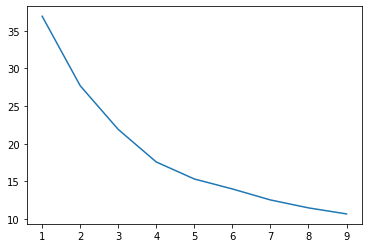

In [745]:
import matplotlib.pyplot as plt
plt.plot(k_num,inertia)

As you can see, the inertia drops very quickly as we increase k up to 5, but then it
decreases much more slowly as we keep increasing k. This curve has roughly the
shape of an arm, and there is an “elbow” at k=5 so if we did not know better, it would
be a good choice

Buid up K-means Clustering model with K=5 

In [746]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

#LA_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 2, 3, 0, 3, 3, 3, 3, 1], dtype=int32)

#### K-Means Clustering Visualization

Prepare dataset for visulazation by using folium map. Specifically, we need longitude and latitude data to place markers on the map.

In [761]:
df_NO_GriffithPark=df_all_attributes_.drop([76])
df_NO_GriffithPark.head()

,Neighborhood,Total_Restaurant,longitude,latitude,sqmi,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count,Population_density,Crime_rate,Restaurant_density
0,Acton,0,-118.169810,34.497355,39.339109,7686.0,102877.500000,1500.000000,28.276378,195.378091,367.894588,0.000000
1,Adams-Normandie,4,-118.300208,34.031461,0.805350,18255.0,34859.600000,984.200000,130.236679,22667.158060,713.430179,4.966783
2,Agoura Hills,12,-118.759885,34.146736,8.146760,19336.0,130459.666667,2488.000000,42.256891,2373.458810,218.539981,1.472978
3,Agua Dulce,0,-118.317104,34.504927,31.462632,4080.0,84048.000000,1516.090091,6.184458,129.677644,151.579862,0.000000
4,Alhambra,2,-118.136512,34.085539,7.623814,84647.0,59975.250000,1245.750000,469.077248,11102.972423,554.156967,0.262336


Let's create a new dataframe that includes the cluster labels.

In [763]:
# add clustering labels
df_NO_GriffithPark.insert(0, 'Cluster Labels', kmeans.labels_)

LA_merged = df_NO_GriffithPark

# # # merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
# LA_merged = LA_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# # #convert from float to integer for cluster labels for later use
# LA_merged=LA_merged.dropna()
# # df_map=df_all_attributes_clustering_
LA_merged['Cluster Labels']=LA_merged['Cluster Labels'].astype('int')

# #pd.set_option("display.max_rows", None, "display.max_columns", None)

LA_merged.head() 

,Cluster Labels,Neighborhood,Total_Restaurant,longitude,latitude,sqmi,Population_Count,Median_Income_amount,Median_rent_amount,Crime_count,Population_density,Crime_rate,Restaurant_density
0,3,Acton,0,-118.169810,34.497355,39.339109,7686.0,102877.500000,1500.000000,28.276378,195.378091,367.894588,0.000000
1,4,Adams-Normandie,4,-118.300208,34.031461,0.805350,18255.0,34859.600000,984.200000,130.236679,22667.158060,713.430179,4.966783
2,2,Agoura Hills,12,-118.759885,34.146736,8.146760,19336.0,130459.666667,2488.000000,42.256891,2373.458810,218.539981,1.472978
3,3,Agua Dulce,0,-118.317104,34.504927,31.462632,4080.0,84048.000000,1516.090091,6.184458,129.677644,151.579862,0.000000
4,0,Alhambra,2,-118.136512,34.085539,7.623814,84647.0,59975.250000,1245.750000,469.077248,11102.972423,554.156967,0.262336


Finally let's visulaize the resulitng clusters.

In [764]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_merged['latitude'], LA_merged['longitude'], LA_merged['Neighborhood'], LA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [914]:
from IPython.display import Image
Image(url= "https://github.com/guochen-code/Coursera_Capstone/blob/main/Final%20Shot-02.png?raw=true", width=1000, height=700)

#### Examine Clusters

Normalize dataset for later use in boxplot. It is much easier to compare these clusters in different plots that all have the same scale.

In [896]:
# normalize the dataset
df_scale=LA_merged.drop(['Cluster Labels','Neighborhood','Total_Restaurant','longitude','latitude','sqmi','Crime_count','Population_density'],axis=1)
x = df_scale.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)
df_plot=df_scaled.rename(columns={0:'Population_Count',1:'Median_income_amount',2:'Median_rent_amount',3:'Crime_rate',4:'Restaurant_density'})

In [900]:
# add clustering labels and Neighborhood 
lst_label=LA_merged['Cluster Labels']
lst_neighbor=LA_merged['Neighborhood']

In [901]:
df_plot.insert(0,'Neighborhood',lst_neighbor)
df_plot.insert(0,'Cluster Labels',lst_label)
df_plot.head()

,Cluster Labels,Neighborhood,Population_Count,Median_income_amount,Median_rent_amount,Crime_rate,Restaurant_density
0,3.0,Acton,0.038385,0.480301,0.304348,0.000353,0.000000
1,4.0,Adams-Normandie,0.091169,0.091270,0.124939,0.000684,0.196375
2,2.0,Agoura Hills,0.096568,0.638058,0.648000,0.000210,0.058238
3,3.0,Agua Dulce,0.020376,0.372605,0.309944,0.000145,0.000000
4,0.0,Alhambra,0.422745,0.234920,0.215913,0.000532,0.010372


Let's look at these five clusters one by one:

In [902]:
Cluster_0=df_plot.loc[df_plot['Cluster Labels'] == 0, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
Cluster_0

,Neighborhood,Population_Count,Median_income_amount,Median_rent_amount,Crime_rate,Restaurant_density
4,Alhambra,0.422745,0.234920,0.215913,0.000532,0.010372
16,Baldwin Park,0.372123,0.245754,0.221370,0.000604,0.017500
19,Bellflower,0.385528,0.222484,0.204097,0.000697,0.019146
23,Boyle Heights,0.476238,0.116670,0.125203,0.000907,0.018195
27,Burbank,0.517914,0.349408,0.318896,0.000434,0.009120
28,Canoga Park,0.337109,0.252091,0.264482,0.000777,0.036369
39,Compton,0.541112,0.183241,0.174174,0.000749,0.015414
48,Downey,0.560959,0.299723,0.257028,0.000018,0.037867
49,Downtown,0.266681,0.158985,0.226756,0.003831,0.033861
53,East Los Angeles,0.591509,0.154214,0.139565,0.000502,0.037070


In [903]:
Cluster_1=df_plot.loc[df_plot['Cluster Labels'] == 1, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
Cluster_1

,Neighborhood,Population_Count,Median_income_amount,Median_rent_amount,Crime_rate,Restaurant_density
9,Arlington Heights,0.091434,0.132223,0.161739,0.000743,0.383334
10,Artesia,0.083693,0.252340,0.272348,0.000741,0.411800
20,Beverly Grove,0.106871,0.430255,0.410391,0.002137,0.599535
29,Carthay,0.015996,0.388888,0.401739,0.001975,0.470057
31,Century City,0.012126,0.631459,0.607652,0.001997,0.507898
36,Chinatown,0.118458,0.150876,0.212870,0.000972,1.000000
47,Diamond Bar,0.227961,0.440582,0.444560,0.000299,0.036594
68,Gardena,0.298199,0.213565,0.209530,0.000112,0.121782
86,Hermosa Beach,0.261032,0.217566,0.178758,0.000473,0.127190
94,Industry,0.548099,0.199489,0.198699,0.000410,0.013002


In [904]:
Cluster_2=df_plot.loc[df_plot['Cluster Labels'] == 2, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
Cluster_2

,Neighborhood,Population_Count,Median_income_amount,Median_rent_amount,Crime_rate,Restaurant_density
2,Agoura Hills,0.096568,0.638058,0.648000,0.000210,0.058238
17,Bel-Air,0.035374,0.999454,0.488348,0.000259,0.000000
21,Beverly Hills,0.170732,0.565782,0.591453,0.000055,0.000000
22,Beverlywood,0.018963,0.854052,0.987130,0.000342,0.000000
24,Bradbury,0.005124,0.561075,0.582609,0.000408,0.000000
25,Brentwood,0.166527,0.833503,0.581217,0.000594,0.000000
32,Cerritos,0.250425,0.470523,0.584885,0.000876,0.004463
35,Cheviot Hills,0.043215,0.711896,0.679130,0.000489,0.000000
91,Hollywood Hills West,0.291427,0.131364,0.124760,0.000035,0.000000
99,La Canada Flintridge,0.102401,0.496464,0.439478,0.000223,0.000000


In [905]:
Cluster_3=df_plot.loc[df_plot['Cluster Labels'] == 3, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
Cluster_3

,Neighborhood,Population_Count,Median_income_amount,Median_rent_amount,Crime_rate,Restaurant_density
0,Acton,0.038385,0.480301,0.304348,0.000353,0.000000
3,Agua Dulce,0.020376,0.372605,0.309944,0.000145,0.000000
5,Alondra Park,0.023857,0.353387,0.298783,0.000537,0.000000
6,Altadena,0.220574,0.443047,0.305870,0.000204,0.000000
7,Arcadia,0.275895,0.442057,0.295051,0.000026,0.021274
8,Arleta,0.166157,0.322382,0.348928,0.000309,0.000000
11,Atwater Village,0.055715,0.346743,0.279768,0.000654,0.044502
12,Avalon,0.018399,0.288556,0.278609,0.000269,0.028810
13,Avocado Heights,0.048704,0.285711,0.241565,0.000337,0.026819
14,Azusa,0.215061,0.267116,0.244730,0.001045,0.000000


In [906]:
Cluster_4=df_plot.loc[df_plot['Cluster Labels'] == 4, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
Cluster_4

,Neighborhood,Population_Count,Median_income_amount,Median_rent_amount,Crime_rate,Restaurant_density
1,Adams-Normandie,0.091169,0.091270,0.124939,0.000684,0.196375
15,Baldwin Hills/Crenshaw,0.155435,0.148021,0.151702,0.001531,0.000000
18,Bell Gardens,0.211859,0.126629,0.175498,0.001061,0.047822
26,Broadway-Manchester,0.123716,0.092166,0.175096,0.000855,0.000000
30,Central-Alameda,0.228060,0.108053,0.122748,0.000516,0.018114
34,Chesterfield Square,0.073949,0.106387,0.190377,0.001230,0.124845
37,Citrus,0.077920,0.220528,0.238957,0.000120,0.117259
38,Commerce,0.067387,0.166541,0.121391,0.002050,0.000000
41,Cudahy,0.119312,0.142108,0.183304,0.001884,0.128679
43,Cypress Park,0.048384,0.182804,0.136696,0.000824,0.054575


Let's transform above tabular datasets to graphs which are much more human friendly.

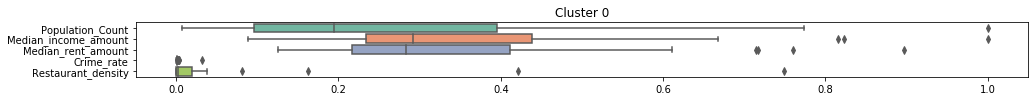

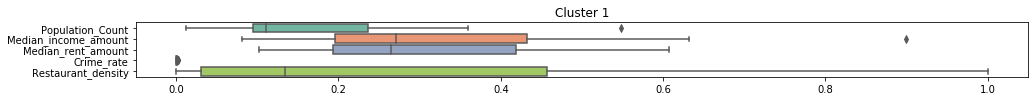

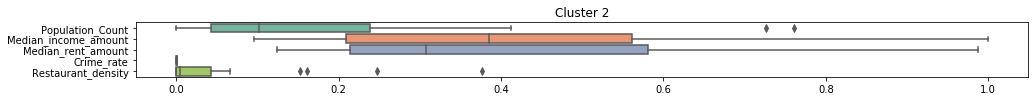

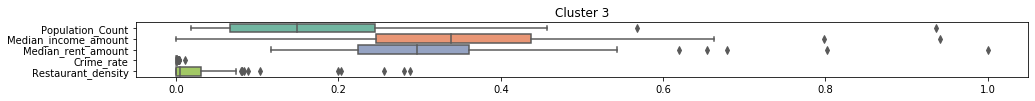

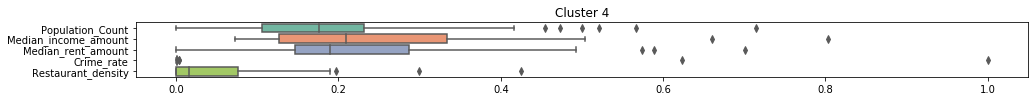

In [907]:
Cluster_0=df_plot.loc[df_plot['Cluster Labels'] == 0, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
plt.figure(figsize=(16, 1))
ax_0 = sns.boxplot(data=Cluster_0, orient="h", palette="Set2").set_title('Cluster 0')
Cluster_1=df_plot.loc[df_plot['Cluster Labels'] == 1, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
plt.figure(figsize=(16, 1))
ax_1 = sns.boxplot(data=Cluster_1, orient="h", palette="Set2").set_title('Cluster 1')
Cluster_2=df_plot.loc[df_plot['Cluster Labels'] == 2, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
plt.figure(figsize=(16, 1))
ax_2 = sns.boxplot(data=Cluster_2, orient="h", palette="Set2").set_title('Cluster 2')
Cluster_3=df_plot.loc[df_plot['Cluster Labels'] == 3, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
plt.figure(figsize=(16, 1))
ax_3 = sns.boxplot(data=Cluster_3, orient="h", palette="Set2").set_title('Cluster 3')
Cluster_4=df_plot.loc[df_plot['Cluster Labels'] == 4, df_plot.columns[[1]+[2]+[3]+[4]+[5]+[6]]]
plt.figure(figsize=(16, 1))
ax_4 = sns.boxplot(data=Cluster_4, orient="h", palette="Set2").set_title('Cluster 4')

## Results and Discussion <a name="results"></a>

In summary, **Cluster 0** seems to be the winner cluster as it possess large population base, intermediate to high household income, low rent cost, low crime rate and low restaurant density.

**Cluster 1**’s relatively smaller population base, lower household income, and highest restaurant density — making this cluster the least desirable option.

**Cluster 2** is  promising in terms of its great household income and lowest normalized crime rate. However, it has smaller population base and much higher rent cost and restaurant density in comparison to Cluster 0.

**Cluster 3** has relatively small population base, intermediate household income and rent cost, intermediate to low restaurant density and relatively high crime rate.

**Cluster 4**, though favorable concerning its lowest rent cost, its lowest household income and high restaurant density would unfortunately demonstrate a strong competition and weak spending power.

So let's focus on Cluster 0 to find our best candidate neighborhood:

In [908]:
Cluster_0

,Neighborhood,Population_Count,Median_income_amount,Median_rent_amount,Crime_rate,Restaurant_density
4,Alhambra,0.422745,0.234920,0.215913,0.000532,0.010372
16,Baldwin Park,0.372123,0.245754,0.221370,0.000604,0.017500
19,Bellflower,0.385528,0.222484,0.204097,0.000697,0.019146
23,Boyle Heights,0.476238,0.116670,0.125203,0.000907,0.018195
27,Burbank,0.517914,0.349408,0.318896,0.000434,0.009120
28,Canoga Park,0.337109,0.252091,0.264482,0.000777,0.036369
39,Compton,0.541112,0.183241,0.174174,0.000749,0.015414
48,Downey,0.560959,0.299723,0.257028,0.000018,0.037867
49,Downtown,0.266681,0.158985,0.226756,0.003831,0.033861
53,East Los Angeles,0.591509,0.154214,0.139565,0.000502,0.037070


Frome above list, **Glendale** stands out from these neighborhoods as the best neighborhood in this cluster for its largest population base, good household income and rent cost, excellent public safety and very low restaurant density.

## Conclusion <a name="conclusion"></a>

In this study, I have labeled the neighbourhoods corresponding to their attributes — population base, household income, rent cost, crime rate and restaurant density etc. The most promising group of neighbourhoods appears to be **Cluster 0**. Out of which,  **Glendale** seems to be the optimal neighborhood. Its large population base and low existing restaurant density indicates a strong demand. The good spending power of the neighbourhood allows them to readily afford the upscaled prices. Lastly, its very low crime rate provides a safety public environment.

However, whenever there is a shift in the dynamic of business demands, we could always target different clusters of neighborhoods. For example, if the client has plans to expand a well-established franchised restaurant, neighbourhoods in ‘Cluster 2’ would be the optimal; this is under the assumption that the aforementioned restaurant would have a competitive advantage of brand loyalty against the high number of competitors in that neighbourhood.

In conclusion, the extensive analysis above would greatly increase the likelihood of the restaurant’s success.

## Future Direction <a name="Future Direction"></a>

I think the study can be carried further by analyzing more characteristics of Glendale such as race/ethnicity with more demographic data to answer a question of what kind of restaurant is most popular. In addition, we can further focus on Glendale area and within it create clusters of locations that meet some basic requirements established in discussion with stakeholders. For instance, we will take into consideration locations with no more than two restaurants in radius of 250 meters, and we want locations without specific kind of restaurants in radius of 400 meters.

With regard to Foursquare API, model accuracy can be improved if we search venues in each neighborhood limited by the coordinates of its border lines instead of using its central point and a given radius. 

## Reference <a name="reference"></a>

[1] My Github for this project: https://github.com/guochen-code/Coursera_Capstone/blob/main/Final_Capstone_The-Battle-of-the-Neighborhoods-LA.ipynb

[2] Neighborhood Data for Social Change (NDSC) platform: https://la.myneighborhooddata.org/data/

[3] Foursquare Developer API: https://developer.foursquare.com